<a href="https://colab.research.google.com/github/kianakiaei/TensorFlow/blob/main/03_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing car in front

## Get the data

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.


> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.6.0
TF Hub version: 0.12.0
GPU available (YESSSS!!!!!)


In [2]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-01 15:16:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M   176MB/s    in 0.6s    

2021-11-01 15:16:48 (176 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.


In [3]:
!ls pizza_steak

test  train


In [4]:
!ls pizza_steak/train/

pizza  steak


In [5]:
!ls pizza_steak/train/steak/ 

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [6]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'pizza_steak'.
There are 2 directories and 1 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 1 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [7]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [8]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
class_names = class_names[1:] # for remove '.DS_Store'
print(class_names)

['pizza' 'steak']


> 🤔 **Note:** Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Visualize, visualize, visualize.**

In [9]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + "/" + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


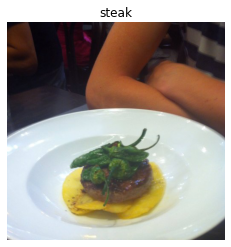

In [10]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train",
                        target_class="steak")

Image shape: (384, 512, 3)


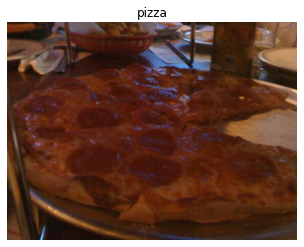

In [11]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train",
                        target_class="pizza")

In [12]:
# View the image shape
img.shape # returns (width, height, colour channels)

(384, 512, 3)

In [13]:
# View the img (actually just a big array/tensor)
img

array([[[ 61,  26,   7],
        [ 52,  19,   0],
        [ 47,  16,   0],
        ...,
        [145, 110,  90],
        [142, 107,  87],
        [139, 104,  85]],

       [[ 70,  32,  11],
        [ 64,  27,   8],
        [ 59,  24,   4],
        ...,
        [143, 108,  86],
        [141, 104,  85],
        [138, 101,  83]],

       [[ 85,  39,  15],
        [ 80,  35,  12],
        [ 75,  33,   9],
        ...,
        [147, 111,  89],
        [144, 107,  88],
        [142, 105,  86]],

       ...,

       [[ 90,  59,  30],
        [ 95,  64,  35],
        [ 99,  68,  40],
        ...,
        [ 80,  56,  28],
        [ 84,  61,  30],
        [ 85,  62,  31]],

       [[ 88,  59,  29],
        [ 91,  62,  32],
        [ 95,  64,  36],
        ...,
        [ 86,  62,  34],
        [ 89,  65,  37],
        [ 90,  67,  36]],

       [[ 93,  64,  34],
        [ 94,  65,  35],
        [ 94,  64,  36],
        ...,
        [ 92,  68,  40],
        [ 92,  68,  40],
        [ 91,  68,  37]]

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [14]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.23921569, 0.10196078, 0.02745098],
        [0.20392157, 0.0745098 , 0.        ],
        [0.18431373, 0.0627451 , 0.        ],
        ...,
        [0.56862745, 0.43137255, 0.35294118],
        [0.55686275, 0.41960784, 0.34117647],
        [0.54509804, 0.40784314, 0.33333333]],

       [[0.2745098 , 0.1254902 , 0.04313725],
        [0.25098039, 0.10588235, 0.03137255],
        [0.23137255, 0.09411765, 0.01568627],
        ...,
        [0.56078431, 0.42352941, 0.3372549 ],
        [0.55294118, 0.40784314, 0.33333333],
        [0.54117647, 0.39607843, 0.3254902 ]],

       [[0.33333333, 0.15294118, 0.05882353],
        [0.31372549, 0.1372549 , 0.04705882],
        [0.29411765, 0.12941176, 0.03529412],
        ...,
        [0.57647059, 0.43529412, 0.34901961],
        [0.56470588, 0.41960784, 0.34509804],
        [0.55686275, 0.41176471, 0.3372549 ]],

       ...,

       [[0.35294118, 0.23137255, 0.11764706],
        [0.37254902, 0.25098039, 0.1372549 ],
        [0.38823529, 0

## An end-to-end example

Let's build a convolutional neural network to find patterns inour images, more specifically we need a way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 43s 254ms/step - loss: 0.5310 - accuracy: 0.7387 - val_loss: 0.3842 - val_accuracy: 0.8360
Epoch 2/5
47/47 [==============================] - 11s 235ms/step - loss: 0.4142 - accuracy: 0.8200 - val_loss: 0.3426 - val_accuracy: 0.8540
Epoch 3/5
47/47 [==============================] - 11s 237ms/step - loss: 0.3901 - accuracy: 0.8247 - val_loss: 0.4337 - val_accuracy: 0.7720
Epoch 4/5
47/47 [==============================] - 11s 239ms/step - loss: 0.3555 - accuracy: 0.8453 - val_loss: 0.3112 - val_accuracy: 0.8920
Epoch 5/5
47/47 [==============================] - 11s 239ms/step - loss: 0.3319 - accuracy: 0.8573 - val_loss: 0.3011 - val_accuracy: 0.8780


In [16]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

> spend 10-minutes playing around the incredible [CNN explainer website](https://poloclub.github.io/cnn-explainer/).

## Using the same model as before - non CNN model

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 10s 207ms/step - loss: 0.9927 - accuracy: 0.5080 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 9s 198ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 9s 199ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 9s 200ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 204ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


our model ran but it doesn't seem like it learned anything. It only reaches 50% accuracy on the training and test sets which in a binary classification problem is as good as guessing.

In [18]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20xmore parameters than our CNN (model_1), model_2 performs terrubly... Let's try to improve it.

In [19]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 214ms/step - loss: 2.7502 - accuracy: 0.6173 - val_loss: 0.6681 - val_accuracy: 0.7700
Epoch 2/5
47/47 [==============================] - 10s 204ms/step - loss: 0.9627 - accuracy: 0.6893 - val_loss: 0.4952 - val_accuracy: 0.7800
Epoch 3/5
47/47 [==============================] - 10s 204ms/step - loss: 0.6346 - accuracy: 0.7340 - val_loss: 0.4464 - val_accuracy: 0.7900
Epoch 4/5
47/47 [==============================] - 10s 203ms/step - loss: 0.4995 - accuracy: 0.7800 - val_loss: 0.4699 - val_accuracy: 0.8000
Epoch 5/5
47/47 [==============================] - 10s 206ms/step - loss: 0.6086 - accuracy: 0.7480 - val_loss: 0.4283 - val_accuracy: 0.8160


In [20]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


the number of trainable parameters has increased even more than `model_2`. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, `model_3` still doesn't out perform `model_1`.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## Binary classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model, the main step here was scsling/normalizing & turning our data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied (experiment, experiment, experiment...)


### 1. Become one with the data

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


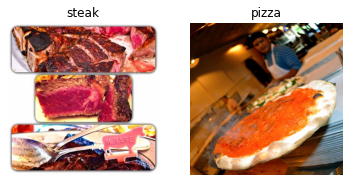

In [88]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train", "pizza")

### 2. Preprocess the data (prepare it for a model)

In [22]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**.

A **batch** is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

There are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for each of our datasets.

In [23]:
# Create train and test data generators and rescale the data 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [24]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               target_size=(224, 224), # Target size of images (height, width)
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [25]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [26]:
# How many batches are there?
len(train_data)

47

In [27]:
1500/32

46.875

In [28]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

Due to our `rescale` parameter, the images are now in `(224, 224, 3)` shape tensors with values between 0 and 1.

In [29]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)

To begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note:** In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In [30]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [31]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, # filter is the number of sliding windows going across an input (higher = more complex model)
         kernel_size=3, # the size of the sliding window going across an input. can write as tuple like (3, 3)
         strides=1, # the size of the step of the sliding window takes across an input. can write as tuple like (1, 1)
         padding='valid', # if "same", output shape is same as input shape, if "valid", output shape gets compressed
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (working with binary classification so only 1 output neuron)
])

We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

```
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
```

Let's discuss some of the components of the `Conv2D` layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

In [32]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [33]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


input shape is (224, 224, 3). Since the padding is valid, the output shape will be (222, 222, 3)

### 4. Fit a model

two new parameters here:
* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [34]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [35]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 250ms/step - loss: 1.1165 - accuracy: 0.6767 - val_loss: 0.5041 - val_accuracy: 0.7420
Epoch 2/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4600 - accuracy: 0.7920 - val_loss: 0.4162 - val_accuracy: 0.8100
Epoch 3/5
47/47 [==============================] - 11s 234ms/step - loss: 0.3569 - accuracy: 0.8553 - val_loss: 0.4318 - val_accuracy: 0.8000
Epoch 4/5
47/47 [==============================] - 11s 236ms/step - loss: 0.1995 - accuracy: 0.9320 - val_loss: 0.3900 - val_accuracy: 0.8280
Epoch 5/5
47/47 [==============================] - 11s 236ms/step - loss: 0.0617 - accuracy: 0.9860 - val_loss: 0.5284 - val_accuracy: 0.8060


In [36]:
model_1.evaluate(test_data)

16/16 [==============================] - 3s 156ms/step - loss: 0.3011 - accuracy: 0.8780


[0.30106523633003235, 0.878000020980835]

`model_1` is better than `model_4`

In [37]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

### 5. Evaluation our model

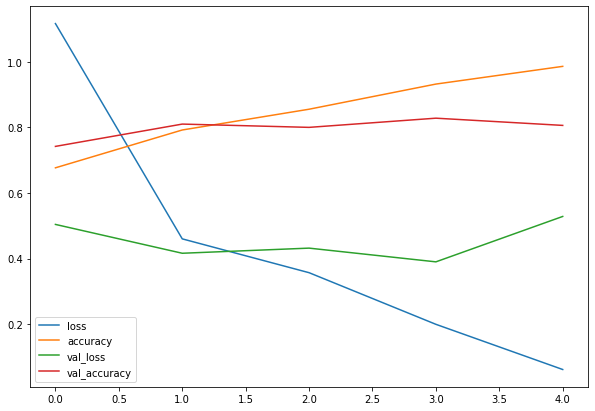

In [38]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished.

In [39]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

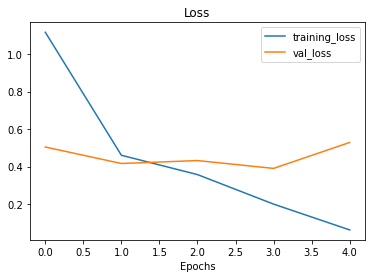

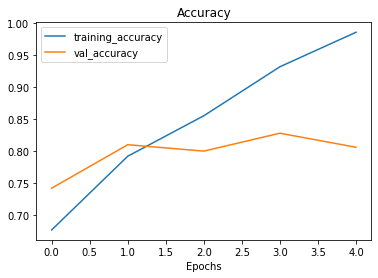

In [40]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

### 6. Adjust the model parameters

Fitting a machine learning model  comes in 3 steps:

0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:
* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.


Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:
* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

```
Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
```

Now built model same structure as `model_4` but with a [`MaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer after each convolutional layer.

In [41]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [42]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [43]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 11s 216ms/step - loss: 0.6409 - accuracy: 0.6120 - val_loss: 0.4743 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 10s 206ms/step - loss: 0.4736 - accuracy: 0.7827 - val_loss: 0.5325 - val_accuracy: 0.7200
Epoch 3/5
47/47 [==============================] - 10s 206ms/step - loss: 0.4438 - accuracy: 0.8013 - val_loss: 0.3586 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 10s 208ms/step - loss: 0.3997 - accuracy: 0.8340 - val_loss: 0.3562 - val_accuracy: 0.8420
Epoch 5/5
47/47 [==============================] - 10s 211ms/step - loss: 0.3849 - accuracy: 0.8367 - val_loss: 0.3400 - val_accuracy: 0.8660


It looks like our model with max pooling (`model_5`) is performing worse on the training set but better on the validation set.

In [44]:
# Check out the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

`MaxPooling2D` layer gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each Conv2D layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

Time to check out the loss curves.

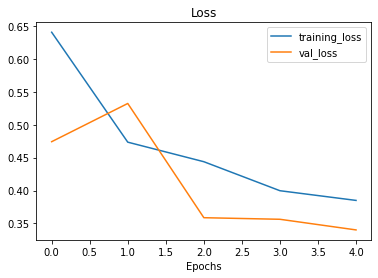

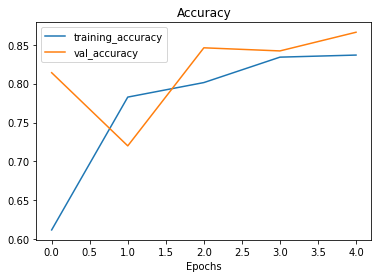

In [45]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Now try another method of overfitting prevention called **data augmentation**.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

> 🤔 **Question:** What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

> 🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [46]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [47]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [48]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

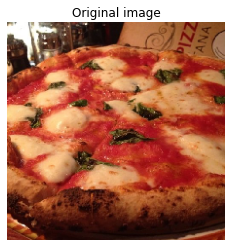

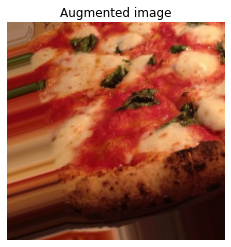

In [49]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

> 🤔 **Question:** Should I use data augmentation? And how much should I augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

Let's try and refit a model same as `model_5` on it and see how it affects training.


In [50]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 26s 532ms/step - loss: 0.7305 - accuracy: 0.4667 - val_loss: 0.6885 - val_accuracy: 0.5060
Epoch 2/5
47/47 [==============================] - 25s 532ms/step - loss: 0.6892 - accuracy: 0.5560 - val_loss: 0.6749 - val_accuracy: 0.5160
Epoch 3/5
47/47 [==============================] - 25s 528ms/step - loss: 0.6862 - accuracy: 0.5427 - val_loss: 0.6618 - val_accuracy: 0.7460
Epoch 4/5
47/47 [==============================] - 25s 534ms/step - loss: 0.6685 - accuracy: 0.6373 - val_loss: 0.5845 - val_accuracy: 0.8180
Epoch 5/5
47/47 [==============================] - 25s 530ms/step - loss: 0.6176 - accuracy: 0.7067 - val_loss: 0.4931 - val_accuracy: 0.7960


> 🤔 **Question:** Why didn't our model get very good results on the training set to begin with?

It's because when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time. 

Since we only set `shuffle=False` for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting `shuffle=True` on future data generators.

> 🤔 **Question:** Why did our model taking longer?

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

> 🔑 **Note:** One possible method to speed up dataset manipulation would be to look into [TensorFlow's parrallel reads and buffered prefecting options](https://www.tensorflow.org/tutorials/images/data_augmentation).

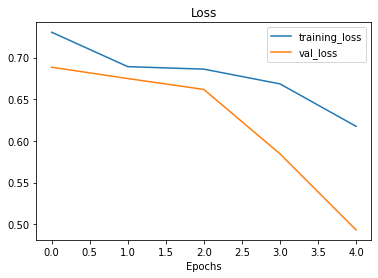

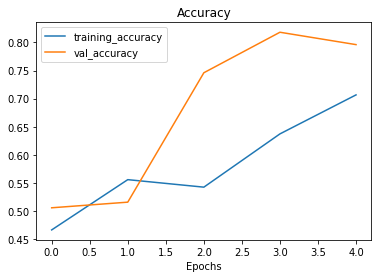

In [51]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent, however, a perfectly smooth loss curve is the equivalent of a fairytale).

Let's see what happens when we shuffle the augmented training data.

In [52]:
# Import data and augment it and shuffle from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [53]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 25s 531ms/step - loss: 0.6115 - accuracy: 0.6520 - val_loss: 0.4528 - val_accuracy: 0.8120
Epoch 2/5
47/47 [==============================] - 25s 523ms/step - loss: 0.5123 - accuracy: 0.7540 - val_loss: 0.3701 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 25s 526ms/step - loss: 0.4757 - accuracy: 0.7773 - val_loss: 0.4724 - val_accuracy: 0.7780
Epoch 4/5
47/47 [==============================] - 24s 520ms/step - loss: 0.4897 - accuracy: 0.7773 - val_loss: 0.5200 - val_accuracy: 0.7320
Epoch 5/5
47/47 [==============================] - 25s 523ms/step - loss: 0.4876 - accuracy: 0.7540 - val_loss: 0.3614 - val_accuracy: 0.8380


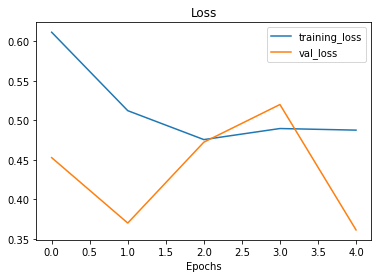

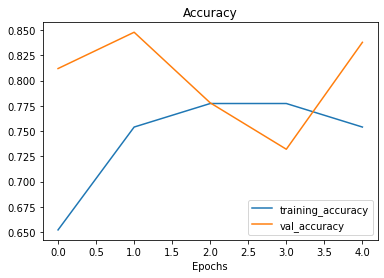

In [54]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

Loss curves look a little bit smoother with shuffled data (comparing `history_6` to `history_7`).

> 🔑 **Note:** When shuffling training data, the model gets exposed to all different kinds of data during, thus enabling it to learn features across a wide array of images.

### 7. Repeat until satisified

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

Let's go back to right where we started and try our original model (`model_1` or the TinyVGG architecture from [CNN explainer](https://poloclub.github.io/cnn-explainer/)).


### Making a prediction with our trained model

To really test it out, we'll upload a couple of our own images and see how the model goes.

--2021-11-01 15:27:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2021-11-01 15:27:23 (31.4 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



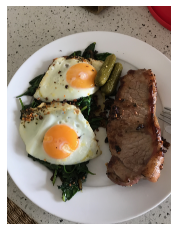

In [55]:
#View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [56]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

`model_7.predict(steak)` not work because shape are not same

Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using [`tf.io.read_file`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) (for readining files) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) (for resizing our image and turning it into a tensor).

> 🔑 **Note:** For your model to make predictions on unseen data, for example, your own custom images, the custom image has to be in the same shape as your model has been trained on. In more general terms, to make predictions on custom data it has to be in the same form that your model has been trained on.

In [57]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [58]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

But it still does not work.

Although our image is in the same shape as the images our model has been trained on, we're still missing a dimension.

Remember how our model was trained in batches?

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of `(batch_size, 224, 224, 3)`.

We can fix this by adding an extra to our custom image tensor using [`tf.expand_dims`](https://www.tensorflow.org/api_docs/python/tf/expand_dims).

In [59]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [60]:
# Make a prediction on custom image tensor
pred = model_1.predict(steak)
pred

array([[0.9682248]], dtype=float32)

The predictions come out in **prediction probability** form. In other words, this means how likely the image is to be one class or another.

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the **postive class** (class 1).

And if the prediction probability is under 0.5, according to the model, the predicted class is most likely to be the **negative class** (class 0).

> 🔑 **Note:** The 0.5 cutoff can be adjusted to your liking. For example, you could set the limit to be 0.8 and over for the positive class and 0.2 for the negative class. However, doing this will almost always change your model's performance metrics so be sure to make sure they change in the right direction.

In [61]:
# Remind ourselves of our class names
class_names

array(['pizza', 'steak'], dtype='<U9')

In [62]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

let's write a little function to convert predictions into their class names and then plot the target image.

In [63]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

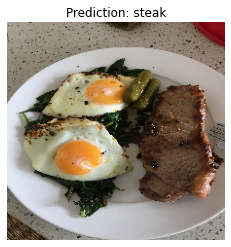

In [64]:
# Test our model on a custom image
pred_and_plot(model_1, "03-steak.jpeg", class_names)

Our model got the prediction right.

--2021-11-01 15:27:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2021-11-01 15:27:26 (43.0 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



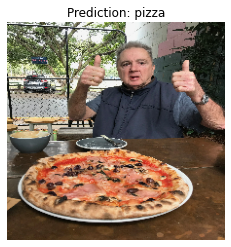

In [65]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_1, "03-pizza-dad.jpeg", class_names)

## Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

### 1. Import and become one with the data

In [66]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-01 15:27:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   158MB/s    in 3.1s    

2021-11-01 15:27:29 (158 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [67]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [68]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [69]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


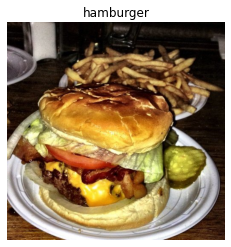

In [70]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Preprocess the data (prepare it for a model)

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


The main change between binary and multi-class classification is that we've changed the `class_mode` parameter to `'categorical'` because we're dealing with 10 classes of food images.

Everything else like rescaling the images, creating the batch size and target image size stay the same.

### 3. Create a model (start with a baseline)

We can use the same model_1 (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_1, except to be multi-class)
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_8.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### 4. Fit a model

In [73]:
# Fit the model
history_8 = model_8.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 57s 241ms/step - loss: 2.2343 - accuracy: 0.1531 - val_loss: 2.1094 - val_accuracy: 0.2208
Epoch 2/5
235/235 [==============================] - 55s 234ms/step - loss: 2.0089 - accuracy: 0.2851 - val_loss: 1.9986 - val_accuracy: 0.2960
Epoch 3/5
235/235 [==============================] - 55s 236ms/step - loss: 1.5956 - accuracy: 0.4636 - val_loss: 2.0185 - val_accuracy: 0.3280
Epoch 4/5
235/235 [==============================] - 54s 232ms/step - loss: 0.9937 - accuracy: 0.6719 - val_loss: 2.4011 - val_accuracy: 0.3024
Epoch 5/5
235/235 [==============================] - 53s 228ms/step - loss: 0.3992 - accuracy: 0.8803 - val_loss: 3.5468 - val_accuracy: 0.2804


### 5. Evaluate the model

In [74]:
# Evaluate on the test data
model_8.evaluate(test_data)

79/79 [==============================] - 12s 151ms/step - loss: 3.5468 - accuracy: 0.2804


[3.5467782020568848, 0.28040000796318054]

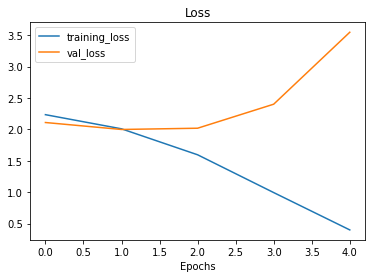

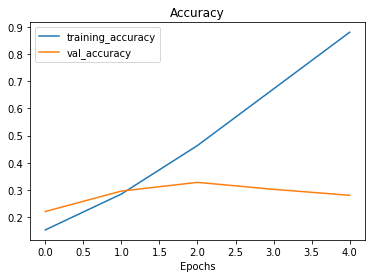

In [75]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_8)

That's quite the gap between the training and validation loss curves.

What does this tell us?

It seems our model is **overfitting** the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.

### 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

> 🔑 **Note:** Preventing overfitting is also referred to as **regularization**.

How about we simplify our model first?

In [76]:
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28090)            

In [77]:
# Try a simplified model (removed two layers)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_9.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_9 = model_9.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 48s 204ms/step - loss: 2.2739 - accuracy: 0.2279 - val_loss: 2.0151 - val_accuracy: 0.2600
Epoch 2/5
235/235 [==============================] - 48s 203ms/step - loss: 1.7817 - accuracy: 0.4004 - val_loss: 1.9402 - val_accuracy: 0.3228
Epoch 3/5
235/235 [==============================] - 48s 203ms/step - loss: 1.4481 - accuracy: 0.5280 - val_loss: 1.9424 - val_accuracy: 0.3396
Epoch 4/5
235/235 [==============================] - 47s 201ms/step - loss: 1.0535 - accuracy: 0.6600 - val_loss: 2.1963 - val_accuracy: 0.3064
Epoch 5/5
235/235 [==============================] - 48s 203ms/step - loss: 0.6698 - accuracy: 0.7997 - val_loss: 2.5079 - val_accuracy: 0.3056


In [78]:
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 10)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 29160)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                291610    
Total params: 292,800
Trainable params: 292,800
Non-trainable params: 0
________________________________________________

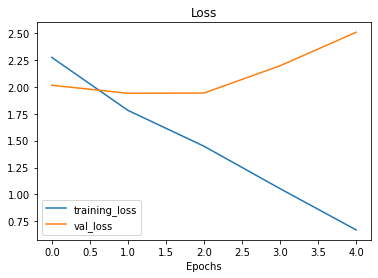

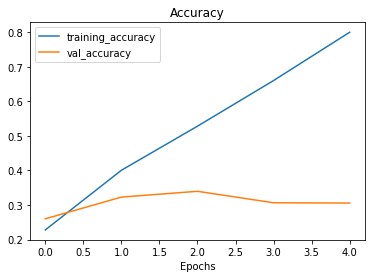

In [79]:
# Check out the loss curves of model_9
plot_loss_curves(history_9)

Even with a simplifed model, it looks like our model is still dramatically overfitting the training data. (we removed 2 layers but the  total params have been increased)

What else could we try?

How about **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

In [80]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model as before (`model_9`).

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) which can take an existing model and rebuild it in the same format. 

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

> 🔑 **Note:** One of the key practices in deep learning and machine learning in general is to **be a serial experimenter**. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [81]:
# Clone the model (use the same architecture model 8 or tinyVGG)
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model (same setup as used for model_8)
model_10.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_10 = model_10.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 126s 535ms/step - loss: 2.2054 - accuracy: 0.1921 - val_loss: 2.0418 - val_accuracy: 0.2592
Epoch 2/5
235/235 [==============================] - 125s 530ms/step - loss: 2.0893 - accuracy: 0.2580 - val_loss: 1.9538 - val_accuracy: 0.3124
Epoch 3/5
235/235 [==============================] - 125s 532ms/step - loss: 2.0253 - accuracy: 0.2875 - val_loss: 1.9381 - val_accuracy: 0.3108
Epoch 4/5
235/235 [==============================] - 125s 533ms/step - loss: 2.0064 - accuracy: 0.2972 - val_loss: 1.8626 - val_accuracy: 0.3712
Epoch 5/5
235/235 [==============================] - 126s 536ms/step - loss: 1.9529 - accuracy: 0.3253 - val_loss: 1.8323 - val_accuracy: 0.3760


In [82]:
model_8.evaluate(test_data)

79/79 [==============================] - 12s 152ms/step - loss: 3.5468 - accuracy: 0.2804


[3.5467777252197266, 0.28040000796318054]

In [83]:
model_10.evaluate(test_data)

79/79 [==============================] - 12s 154ms/step - loss: 1.8323 - accuracy: 0.3760


[1.8323312997817993, 0.37599998712539673]

You can see it each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

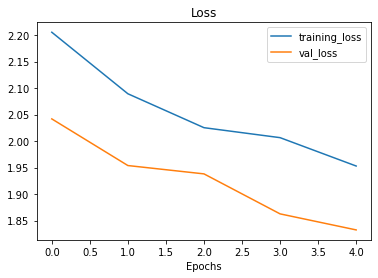

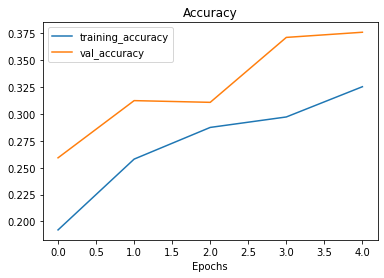

In [84]:
# Check out our model's performance with augmented data
plot_loss_curves(history_10)

That's looking much better, the loss curves are much closer to eachother. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.

### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time and  **transfer learning**.

## Making a prediction with our trained model

In [85]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

Now let's get some of our custom images.

In [86]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

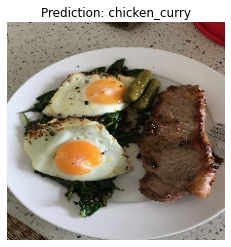

In [87]:
# Make a prediction using model_10
pred_and_plot(model=model_10, 
              filename="03-steak.jpeg", 
              class_names=class_names)

it looks like our model got the prediction wrong, how about we try another?

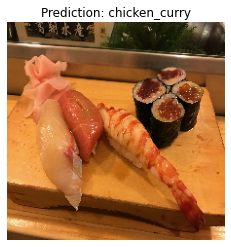

In [93]:
pred_and_plot(model_10, "03-sushi.jpeg", class_names)

And again, it's predicting `chicken_curry` for some reason.

How about one more?

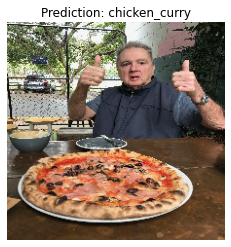

In [94]:
pred_and_plot(model_10, "03-pizza-dad.jpeg", class_names)

`chicken_curry` again? There must be something wrong...

I think it might have to do with our `pred_and_plot` function.

Let's makes a prediction without using the function and see where it might be going wrong.

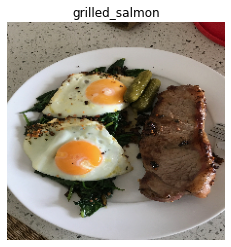

In [96]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_10.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Much better! There must be something up with our `pred_and_plot` function.

And I think I know what it is.

The `pred_and_plot` function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the `predict` function.

In [98]:
# Check the output of the predict function
pred = model_10.predict(tf.expand_dims(img, axis=0))
pred

array([[0.04182581, 0.05232156, 0.08068629, 0.30666572, 0.06931096,
        0.04070462, 0.02518866, 0.11357635, 0.1853607 , 0.08435927]],
      dtype=float32)

Since our model has a `'softmax'` activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) and then use that to index our `class_names` list to output the predicted class.

In [99]:
# Find the predicted class name
class_names[pred.argmax()]

'grilled_salmon'

Knowing this, we can readjust our `pred_and_plot` function to work with multiple classes as well as binary classes.

In [100]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Let's try it out. If we've done it right, using different images should lead to different outputs (rather than `chicken_curry` every time).

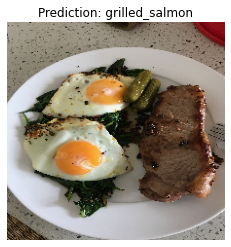

In [101]:
pred_and_plot(model_10, "03-steak.jpeg", class_names)

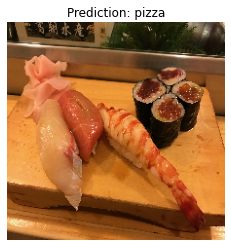

In [102]:
pred_and_plot(model_10, "03-sushi.jpeg", class_names)

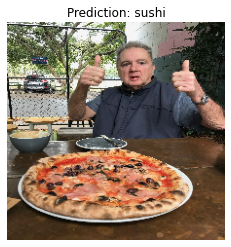

In [103]:
pred_and_plot(model_10, "03-pizza-dad.jpeg", class_names)

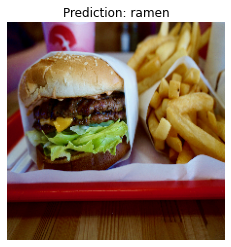

In [104]:
pred_and_plot(model_10, "03-hamburger.jpeg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~40% accuracy on the test dataset.